### Problem Narrative:
When traveling to Paris and booking Airbnb for a vacation, I try to spend less on lodging to be able to afford good dining and tours.  I find that the options close to the centre, that is close to the top attractions i.e. Eiffel tower, Champs Elysees are pricier, and most of the properties are unavailable as well, so I end up staying further from the centre, and when I do, I am always worried that I might have booked a property that is way too far out from the centre of the city, and or far from a metro station -- since actual location is not provided until after you have made the reservation, or unless you contact host and ask.  Distance to the station is relative depending on how far one is willing to walk, but for me, more than a mile to a station is considered far, since I feel I have to save all my energy for the leisurely walking one does around Paris.

The goals are:

1) to be able to explore and answer the following questions:

* How does location influence property rental price and reviews?  What are the options for being able to stay close to the centre?

* What other features drive the price of an airbnb rental property?

  i.e. price vs location, price vs distance from a top attraction, etc.



2) recommend Airbnb properties given a certain criteria, and enable a more informed decision for the traveler: TBD

* walking distance to one of the top attractions (within 2 miles)
* walking distance to metro station (within 1 mile)
* rating >= 9

* other user defined criteria i.e. 
* number of beds
* number of bedrooms
* price range
* type of property

** Some caveats and assumptions:
Property locations provided by Airbnb in the dataset are a few meters off than the actual property.



In [1]:
%matplotlib inline
%config InlineBackend.figure.format = 'retina'

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster", font_scale=1.3)
import folium

In [3]:
import pandas as pd
import numpy as np
import json
import ijson
from datetime import datetime, timedelta

In [4]:
import os, sys
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pivottablejs
import missingno as msno
import pandas_profiling

import ipywidgets as widgets

import sklearn
import scipy


In [6]:
mpl_update = {'font.size':16,
              'xtick.labelsize':14,
              'ytick.labelsize':14,
              'figure.figsize':[12.0,8.0],
              'axes.color_cycle':['#0055A7', '#2C3E4F', '#26C5ED', '#00cc66', '#D34100', '#FF9700','#091D32'], 
              'axes.labelsize':16,
              'axes.labelcolor':'#677385',
              'axes.titlesize':20,
              'lines.color':'#0055A7',
              'lines.linewidth':3,
              'text.color':'#677385'}
mpl.rcParams.update(mpl_update)

In [7]:
json_data_path = 'airbnb_paris/airbnb-listings.geojson.json'
with open(json_data_path, 'r') as f:
    objects = ijson.items(f, 'features.item')
    columns = list(objects)

In [8]:
#check that the expected number of rows have been read
len(columns)

54513

In [9]:
selected_row = []
for col in columns:
    temp = col['properties']
    selected_row.append(temp)

In [10]:
len(selected_row)

54513

In [11]:
#load all rows to a dataframe
df = pd.DataFrame(selected_row)
pd.set_option('display.max_columns',500)

In [12]:
len(df.columns)

86

In [13]:
df.columns

Index(['access', 'accommodates', 'amenities', 'availability_30',
       'availability_365', 'availability_60', 'availability_90', 'bathrooms',
       'bed_type', 'bedrooms', 'beds', 'calculated_host_listings_count',
       'calendar_last_scraped', 'calendar_updated', 'cancellation_policy',
       'city', 'cleaning_fee', 'country', 'country_code', 'description',
       'experiences_offered', 'extra_people', 'features', 'first_review',
       'geolocation', 'guests_included', 'host_about', 'host_id',
       'host_listings_count', 'host_location', 'host_name',
       'host_neighbourhood', 'host_picture_url', 'host_response_rate',
       'host_response_time', 'host_since', 'host_thumbnail_url',
       'host_total_listings_count', 'host_url', 'host_verifications',
       'house_rules', 'id', 'interaction', 'jurisdiction_names', 'last_review',
       'last_scraped', 'latitude', 'license', 'listing_url', 'longitude',
       'market', 'maximum_nights', 'medium_url', 'minimum_nights',
       'm

1) Delete unnecessary columns which will not be used for analysis, such as:
    calendar_last_scraped, calendar_updated, city, listing_url, host_picture_url, etc.

In [14]:
dfParis = df[['access','accommodates','amenities','availability_30','availability_60','availability_90','bathrooms','bedrooms','beds',
              'cancellation_policy','cleaning_fee','guests_included','host_since','host_total_listings_count',
              'id','last_review','latitude','longitude','minimum_nights','neighborhood_overview','neighbourhood_cleansed',
              'number_of_reviews','price','property_type','review_scores_accuracy','review_scores_checkin',
              'review_scores_cleanliness','review_scores_communication','review_scores_location',
              'review_scores_rating','review_scores_value','reviews_per_month','room_type','summary','transit','zipcode']
            ].copy()

2) Look at individual columns and check for unique values

In [15]:
dfParis['neighbourhood_cleansed'].value_counts()

Buttes-Montmartre      6315
Popincourt             5381
Vaugirard              4000
Entrepôt               3749
Batignolles-Monceau    3547
Ménilmontant           2981
Buttes-Chaumont        2951
Passy                  2895
Opéra                  2391
Temple                 2368
Observatoire           2161
Reuilly                2156
Panthéon               1989
Gobelins               1940
Hôtel-de-Ville         1927
Luxembourg             1846
Palais-Bourbon         1709
Bourse                 1620
Élysée                 1459
Louvre                 1128
Name: neighbourhood_cleansed, dtype: int64

In [16]:
dfParis['property_type'].value_counts()

Apartment             52090
Loft                    602
House                   557
Bed & Breakfast         394
Condominium             253
Other                   159
Boutique hotel          114
Townhouse                73
Guesthouse               71
Dorm                     64
Hostel                   33
Boat                     31
Serviced apartment       27
Cabin                    14
Villa                    14
Timeshare                 4
Cave                      2
Igloo                     2
Bungalow                  2
Earth House               2
Camper/RV                 2
Tipi                      1
Treehouse                 1
Chalet                    1
Name: property_type, dtype: int64

In [17]:
dfParis['room_type'].value_counts()

Entire home/apt    46897
Private room        7073
Shared room          543
Name: room_type, dtype: int64

In [18]:
print(dfParis['review_scores_rating'].isnull().sum())
print(dfParis['review_scores_value'].isnull().sum())
print(dfParis['review_scores_cleanliness'].isnull().sum())
print(dfParis['review_scores_accuracy'].isnull().sum())
print(dfParis['review_scores_checkin'].isnull().sum())
print(dfParis['review_scores_communication'].isnull().sum())
print(dfParis['review_scores_location'].isnull().sum())


14250
14375
14330
14355
14378
14335
14368


In [19]:
dfParis['zipcode'].value_counts()

75018           6260
75011           5312
75015           3951
75010           3782
75017           3520
75020           3040
75019           2843
75009           2375
75003           2198
75012           2134
75014           2134
75005           1998
75004           1922
75013           1915
75006           1833
75007           1614
75002           1582
75016           1446
75116           1392
75008           1378
75001           1102
92130             17
75                 4
75000              3
92100              3
93300              3
92300              2
94160              2
75011\n75011       2
Paris              2
92170              1
78005              1
92240              1
750109             1
Montmartre         1
76016              1
75003\n75003       1
Paris 75004        1
075016             1
78008              1
75018e             1
700014             1
adf                1
75106              1
75011 PARIS        1
92200              1
75 018             1
7015         

Researching Paris zip codes, it appears that zip codes 75001 through 75020 corresponds to 1st Arrondissement through 20th Arrondissemant in the city.

More information on Paris Arrondissements in wikipedia: https://en.wikipedia.org/wiki/Arrondissements_of_Paris


Since we want to focus the analysis for properties within Analysis will be focused in these zip codes, we can delete the rows outside of these zip codes.

In [20]:
zipcodes = [str(x) for x in range(75001, 75021) ]
dfParis = dfParis[dfParis['zipcode'].isin(zipcodes)]
dfParis['zipcode'].value_counts()

75018    6260
75011    5312
75015    3951
75010    3782
75017    3520
75020    3040
75019    2843
75009    2375
75003    2198
75014    2134
75012    2134
75005    1998
75004    1922
75013    1915
75006    1833
75007    1614
75002    1582
75016    1446
75008    1378
75001    1102
Name: zipcode, dtype: int64

In [21]:
#get number of rows after deleting other zipcodes
len(dfParis['zipcode'])

52339

Let us add a column 'arrondissement' so we can refer to the area by arrondissement rather than the zip code:

In [22]:
def get_arrond(row):
    ''' this function returns the arrondissement number based on the zipcode'''
    
    return int(row['zipcode'][-2:])

In [24]:
dfParis['arrondissement'] = dfParis.apply(lambda x: get_arrond(x), 1)

In [25]:
def get_arrond_name(row):
    '''this function returns the arrondissement name'''
    names = ['Louvre', 'Bourse', 'Temple', 'Hotel-de-Ville', 'Pantheon', 'Luxembourg',
             'Palais-Bourbon', 'Elysee', 'Opera', 'Entrepot', 'Popincourt', 'Reuilly','Gobelins',
             'Observaitoire', 'Vaugirard', 'Passy', 'Batignolles-Monceau',
             'Butte-Montmartre', 'Buttes-Chaumont', 'Menilmontant']
    return names[row['arrondissement'] - 1]

In [26]:
dfParis['arrond_name'] = dfParis.apply(lambda x: get_arrond_name(x), 1)


In [27]:
dfParis.arrond_name.unique()

array(['Palais-Bourbon', 'Vaugirard', 'Buttes-Chaumont', 'Opera',
       'Butte-Montmartre', 'Menilmontant', 'Reuilly',
       'Batignolles-Monceau', 'Luxembourg', 'Elysee', 'Entrepot',
       'Hotel-de-Ville', 'Popincourt', 'Passy', 'Observaitoire',
       'Pantheon', 'Gobelins', 'Bourse', 'Temple', 'Louvre'], dtype=object)

In [28]:
#check if the neighbourhood_cleansed values are different from the arrondissement name derived
dfParis[dfParis['neighbourhood_cleansed'] != dfParis['arrond_name']][['neighbourhood_cleansed','arrond_name','zipcode']].head()

,neighbourhood_cleansed,arrond_name,zipcode
1,Palais-Bourbon,Vaugirard,75015
23,Opéra,Opera,75009
24,Opéra,Opera,75009
25,Opéra,Opera,75009
26,Opéra,Opera,75009


3) Explore variables with missing values

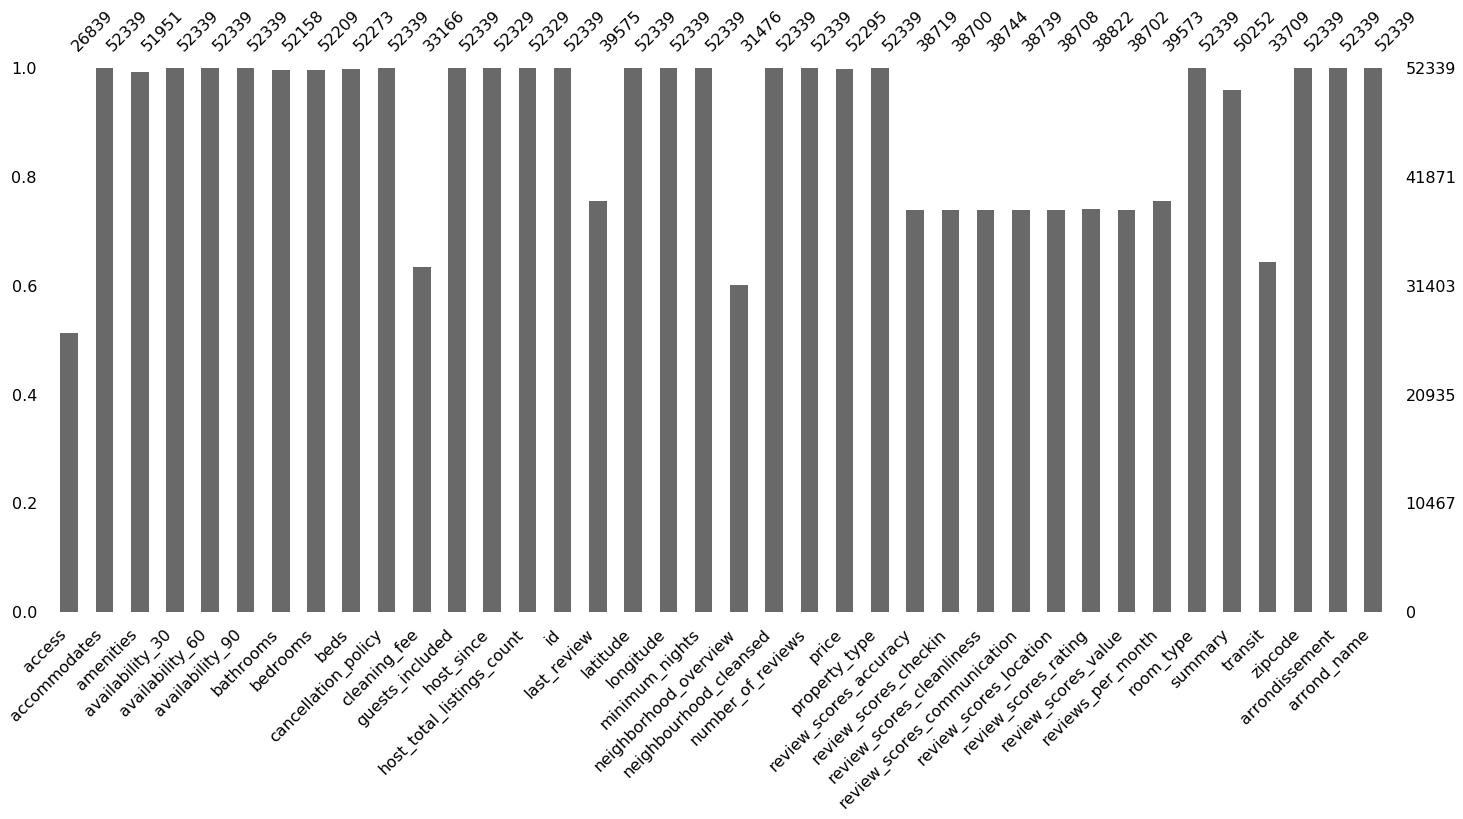

In [29]:
msno.bar(dfParis, labels=True)

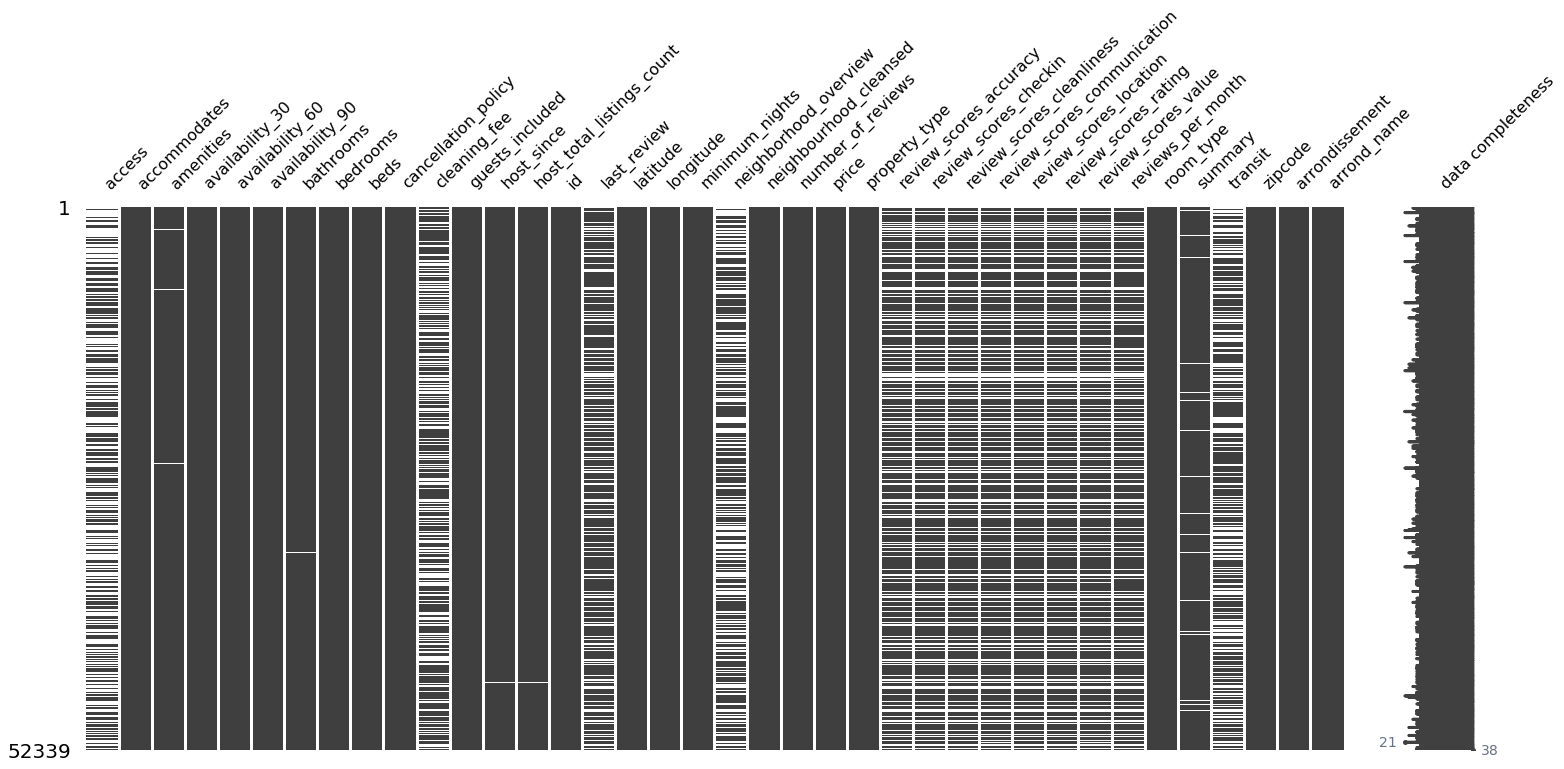

In [30]:
msno.matrix(dfParis, labels=True)

The two graphs above shows that the scores fields do have quite a bit of missing values.

We can label the records as 'rated' vs'unrated', so in our analysis we can compare properties and availabilities for those which are rated, versus those which are not.  Those with incomplete ratings we will label those as well as unrated -- where scores_review_ratings is not populated.

In [31]:
def set_rating_ind(row):
    if np.isnan(row['review_scores_rating']) == True:
        return 0
    else:
        return 1

In [32]:
dfParis['rating_ind'] = dfParis.apply(lambda x: set_rating_ind(x), 1)

We can delete additional columns:  access, cleaning fee, and neighborhood_overview since they will not be relevant in our analysis

In [33]:
try:
    dfParis = dfParis.drop(['access','cleaning_fee','neighborhood_overview'], axis=1)
except:
    print('columns do not exist')

Remove all rows with missing values in the 'price' column, since they will not be useful in the analysis.  

In [34]:
delrows = dfParis[dfParis.price.isnull()]
dfParis = pd.merge(dfParis, delrows[['id']], how='outer', on='id', indicator=True)

try:
    dfParis = dfParis[dfParis['_merge']=='left_only']
    dfParis.drop('_merge', axis=1)
except:
    print('column does not exist')
    
len(dfParis)

52295

In [35]:
dfParis[['availability_30','availability_60', 'availability_90','bathrooms','bedrooms','beds','minimum_nights','price','property_type','review_scores_accuracy','review_scores_checkin',
              'review_scores_cleanliness','review_scores_communication','review_scores_location',
              'review_scores_rating','review_scores_value']].describe().astype(int).T

,count,mean,std,min,25%,50%,75%,max
availability_30,52295,8,10,0,0,3,14,30
availability_60,52295,18,21,0,0,7,35,60
availability_90,52295,29,33,0,0,15,60,90
bedrooms,52165,1,0,0,1,1,1,10
beds,52229,1,1,1,1,1,2,16
minimum_nights,52295,3,62,1,1,2,3,10000
price,52295,93,71,0,55,75,105,999
review_scores_accuracy,38700,9,0,2,9,10,10,10
review_scores_checkin,38681,9,0,2,9,10,10,10
review_scores_cleanliness,38725,9,1,2,9,9,10,10


In [37]:
dfParis.to_pickle('./airbnb_paris/airbnb_Paris_cleansed_06015.p')